In [1]:
import pandas as pd
import re
from sklearn import datasets, model_selection
from sklearn.feature_extraction import text
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold

In [103]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [5]:
from scipy import interp

In [6]:
# import plotting mech
import matplotlib.pyplot as plt


In [7]:
plt.style.use("seaborn")

In [8]:
df= pd.read_csv("creditcard.csv")

In [9]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [10]:
print("number of features = ", len(df.columns)-1)

number of features =  30


In [11]:
print("number of data points = ", len(df))

number of data points =  284807


In [12]:
print("Number of Fraud Transactions = ", len(df.loc[df["Class"]==1]))

Number of Fraud Transactions =  492


In [13]:
# Let us look at the data distribution (See if the classes are truly imbalanced)
class_ratios_ = df.groupby("Class")["Time"].aggregate("count")  # pick any arbitrary column
class_ratios_

Class
0    284315
1       492
Name: Time, dtype: int64

In [14]:
class_ratios_values = class_ratios_.values
class_ratios_labels = np.array(["Non-Frauds", "Frauds"])

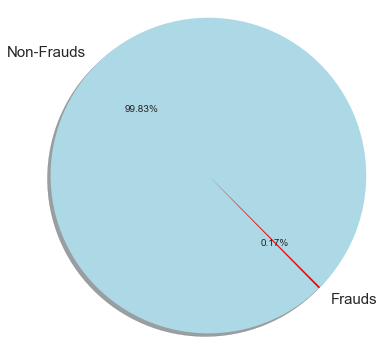

In [15]:
plt.style.use("seaborn")
fig, ax = plt.subplots(nrows=1, ncols=1,figsize= (5,5))
pie_colors = ["lightblue", "red"]
_, texts, _ = ax.pie(class_ratios_values, labels= class_ratios_labels,explode = (0,0), shadow=True, 
        colors=pie_colors, startangle=-45,autopct='%1.2f%%',)
ax.axis('equal')
texts[0].set_fontsize(15)
texts[1].set_fontsize(15)

plt.tight_layout()
plt.show()

In [16]:
# Lets create a new dataset from the df after performing random sampling
def random_sampler(df, ratio=1):
    sample_size = len(df.loc[df["Class"]==1]) * ratio
    non_fraud_ind = df[df["Class"]==0].index
    random_ind = np.random.choice(non_fraud_ind, sample_size, replace=False)  # sampling without replacement
    non_fraud_samples = df.loc[random_ind]
    fraud_samples = df.loc[df["Class"]==1]
    return shuffle(pd.concat([fraud_samples, non_fraud_samples]))


In [17]:
# original data
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
# we need to create instances and labels from the dataframes
# we will create 3 datasets with different sampling ratios (1:1), (2:1), (5:1)

ds1 = random_sampler(df, ratio=1)
ds2 = random_sampler(df, ratio=2)
ds5 = random_sampler(df, ratio=5)
# 1:1
X_rs1 = ds1.iloc[:, :-1]
y_rs1 = ds1.iloc[:, -1]
# 2:1
X_rs2 = ds2.iloc[:, :-1]
y_rs2 = ds2.iloc[:, -1]
# 5:1
X_rs5 = ds5.iloc[:, :-1]
y_rs5 = ds5.iloc[:, -1]

In [18]:
# bring features onto the same scale (Not necessary for decision tree based classifiers but for SVMs it might be)
# We'll see if it is really necessary
# sc = StandardScaler()
# X_std = sc.fit_transform(X)
# len(X_std)

In [33]:
# define classifier pipelines (For SVMs as well as random forests)
svm_pipe = Pipeline([('svm_cls', svm.SVC( kernel="rbf"))])
rf_pipe = Pipeline([('forest', RandomForestClassifier(n_estimators=20, n_jobs=-1, max_features="auto"))])
lr_pipe = Pipeline([('logist', LogisticRegression(random_state=1))])

In [20]:
# define evaluate classifier using confusion matrix
def get_confmat_rocscore(cls, X, y, Xtest, ytest):
    # returns confusion matrix of classifier
    cls.fit(X, y)
    y_pred = cls.predict(Xtest)
    conf_mat = confusion_matrix(y_true=ytest, y_pred=y_pred)
    roc_score = roc_auc_score(y_true=ytest, y_score=y_pred)
    return conf_mat, roc_score

In [21]:
plt.style.use("seaborn")
def plot_conf_matrix(conf_mat, title):
    fig, ax = plt.subplots(figsize=(3,3))
    ax.matshow(conf_mat, cmap=plt.cm.Accent, alpha=0.3)
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.title(title, y= 1.08)
    plt.show()

In [126]:
cm_svm, r_score = get_confmat_rocscore(svm_pipe, X_rs1, y_rs1, X, y)

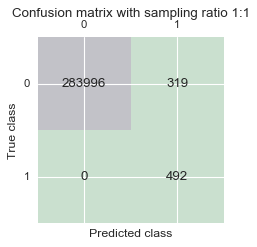

AUROC =  0.999439002515


In [128]:
plot_conf_matrix(cm_svm, "Confusion matrix with sampling ratio 1:1")
print("AUROC = ", r_score)

In [129]:
cm_svm2, r_score2 = get_confmat_rocscore(svm_pipe, X_rs2, y_rs2, X, y)


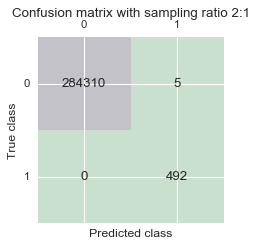

AUROC =  0.999991206936


In [130]:
plot_conf_matrix(cm_svm2, "Confusion matrix with sampling ratio 2:1")
print("AUROC = ", r_score2)

In [105]:
cm_svm5, r_score5 = get_confmat_rocscore(svm_pipe, X_rs5, y_rs5, X, y)

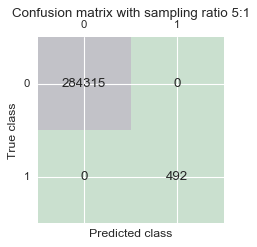

In [106]:
plot_conf_matrix(cm_svm5, "Confusion matrix with sampling ratio 5:1")

In [131]:
cm_rf, r_score = get_confmat_rocscore(rf_pipe, X_rs1, y_rs1, X, y)

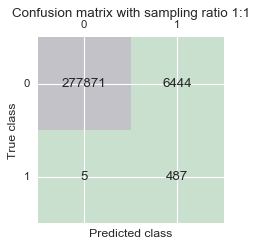

AUROC =  0.983586198264


In [132]:
plot_conf_matrix(cm_rf, "Confusion matrix with sampling ratio 1:1")
print("AUROC = ", r_score)

In [133]:
cm_rf2, r_score2 = get_confmat_rocscore(rf_pipe, X_rs2, y_rs2, X, y)

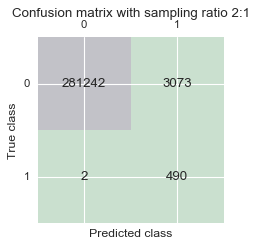

AUROC =  0.983586198264


In [134]:
plot_conf_matrix(cm_rf2, "Confusion matrix with sampling ratio 2:1")
print("AUROC = ", r_score)

In [112]:
# ROC Curves

0

In [26]:
def five_fold_roc_curves(cls,X, y, title=""):
    cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    fig = plt.figure(figsize=(7, 5))
    for i, (train, test) in enumerate(cv.split(X,y)):
        cls_fitted = cls.fit(X.iloc[train], y.iloc[train])
        y_pred = cls_fitted.predict(X.iloc[test])
        fpr, tpr, thresh = roc_curve(y.iloc[test], y_pred, pos_label = 1)
        rocAuc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label = "ROC fold %d (Area = %0.2f)" %(i+1, rocAuc))
    plt.title("ROC Curves "+ title)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend(loc="best")
    plt.show()

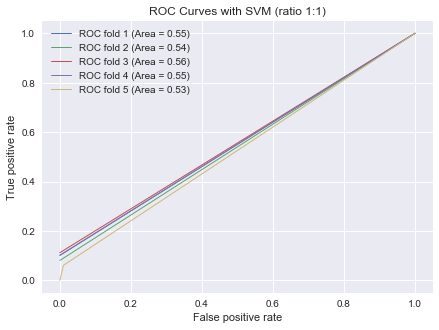

In [27]:
five_fold_roc_curves(svm_pipe, X_rs1, y_rs1, title ="with SVM (ratio 1:1)")

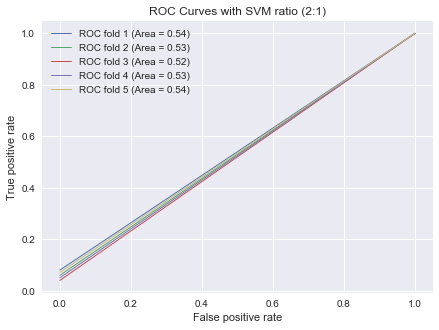

In [28]:
five_fold_roc_curves(svm_pipe, X_rs2, y_rs2, title ="with SVM ratio (2:1)")

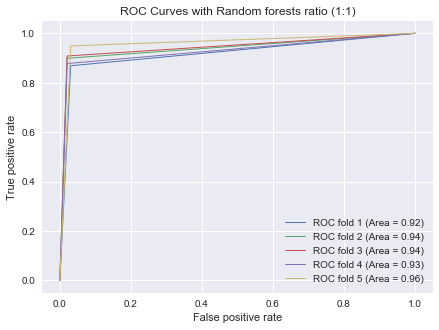

In [29]:
five_fold_roc_curves(rf_pipe, X_rs1, y_rs1, title ="with Random forests ratio (1:1)")

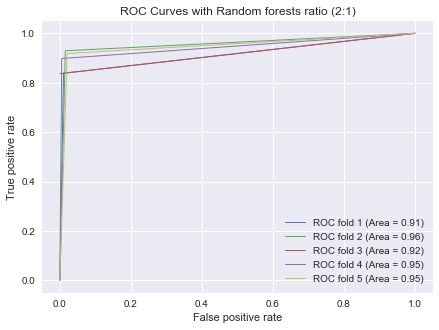

In [30]:
five_fold_roc_curves(rf_pipe, X_rs2, y_rs2, title ="with Random forests ratio (2:1)")

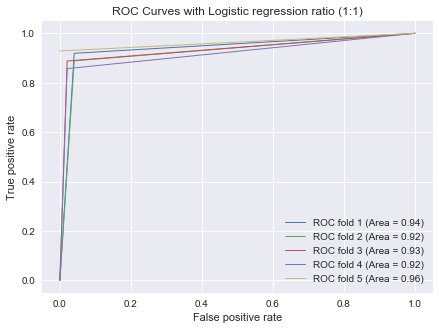

In [34]:
# Let us try out logistic regression
five_fold_roc_curves(lr_pipe, X_rs1, y_rs1, title ="with Logistic regression ratio (1:1)")

In [38]:
# Taking a step back
# Assessing feature importance with random forests
feat_labels = X.columns
forest = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
forest.fit(X_rs1, y_rs1)
importances = forest.feature_importances_
inds = np.argsort(importances)[::-1]
importances

array([ 0.00604891,  0.01009622,  0.0252165 ,  0.04662678,  0.09276503,
        0.00898889,  0.00989282,  0.03322634,  0.01193251,  0.01956742,
        0.12409391,  0.06575489,  0.10260738,  0.00672433,  0.17256957,
        0.00730633,  0.04232534,  0.09412981,  0.01211521,  0.01194346,
        0.0118205 ,  0.01942898,  0.00728337,  0.00723974,  0.00538245,
        0.0061992 ,  0.00670944,  0.01129597,  0.00771433,  0.01299437])

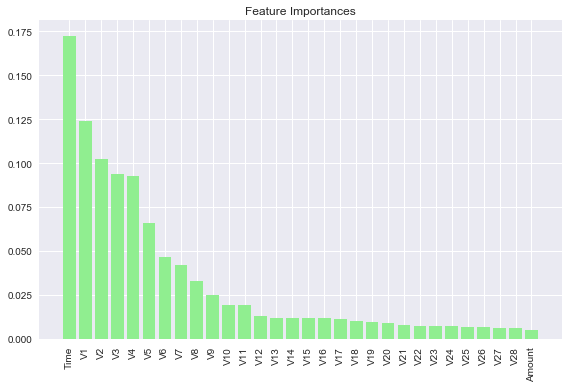

In [40]:
plt.bar(range(len(feat_labels)), importances[inds], color="lightgreen", align="center")
plt.title("Feature Importances")
plt.xticks(range(len(feat_labels)),feat_labels, rotation=90)
plt.tight_layout()
plt.show()

In [58]:
X_rs1_sub = X_rs1.iloc[:, :15]

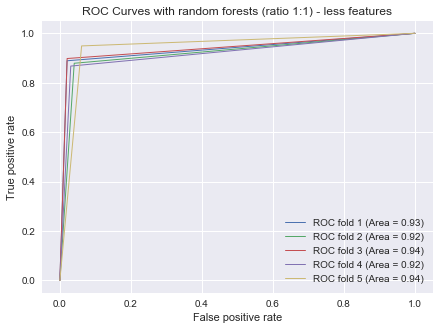

In [60]:
five_fold_roc_curves(rf_pipe, X_rs1_sub, y_rs1, title ="with random forests (ratio 1:1) - less features")

In [83]:
rf_pipe_b = Pipeline([('forest', RandomForestClassifier(n_estimators=250, n_jobs=-1, max_features="auto"))])
# We will now perform grid search to find the best params
sample_split = [90,100,110,120,150,200,250,300]
max_depth = [10,100,200,300,500,1000]
param_grid = [{'forest__min_samples_split':sample_split, 'forest__max_depth':max_depth}]
gs2 = GridSearchCV(estimator=rf_pipe_b, param_grid = param_grid, scoring='roc_auc', cv=10, n_jobs=-1)
gs2 = gs2.fit(X_rs1, y_rs1)

In [84]:
gs2.best_params_

{'forest__max_depth': 500, 'forest__min_samples_split': 90}

In [91]:
rf_pipe_b2 = Pipeline([('forest', RandomForestClassifier(n_estimators=250, n_jobs=-1, max_features="auto", min_samples_split=90, max_depth=500))])


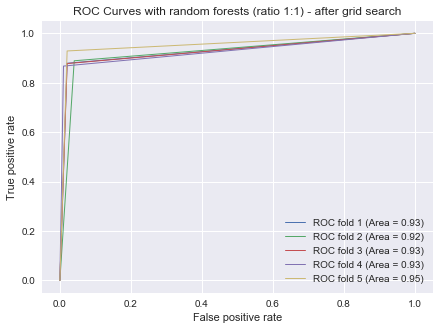

In [92]:
five_fold_roc_curves(rf_pipe_b2, X_rs1, y_rs1, title ="with random forests (ratio 1:1) - after grid search")

In [94]:
from sklearn.model_selection import validation_curve


In [101]:
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
lr_pipe = Pipeline([('cls', LogisticRegression(random_state=1))])
train_scores, test_scores = validation_curve(estimator=lr_pipe, X=X_rs1, y=y_rs1, param_name='cls__C',param_range=param_range,cv=10)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

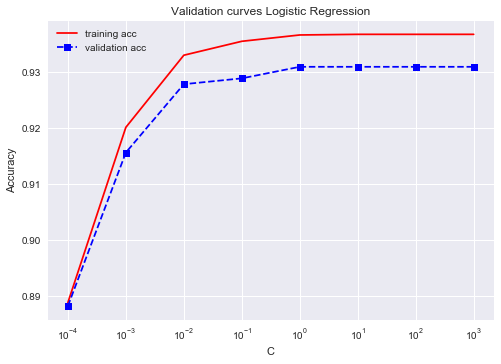

In [102]:
plt.plot(param_range, train_mean, color="red", marker="x", label="training acc")
plt.plot(param_range, test_mean, color="blue", marker="s", label="validation acc" , linestyle='--')
plt.title("Validation curves Logistic Regression")
plt.xscale('log')
plt.legend(loc="best")
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

In [120]:
gb_pipe = Pipeline([('boosting', GradientBoostingClassifier(n_estimators=100))])
max_depth = [1,2,3,4,5,6,7,8,9,10]
train_scores, test_scores = validation_curve(estimator=gb_pipe, X=X_rs1, y=y_rs1, param_name='boosting__max_depth',param_range=max_depth,cv=5)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

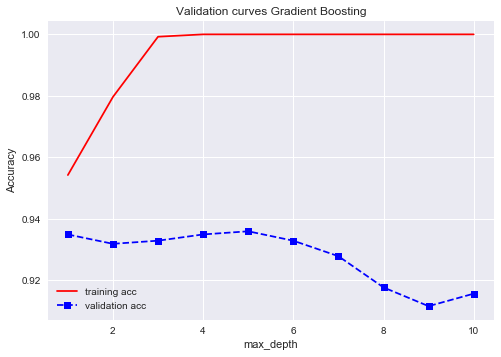

In [121]:
plt.plot(max_depth, train_mean, color="red", marker="x", label="training acc")
plt.plot(max_depth, test_mean, color="blue", marker="s", label="validation acc" , linestyle='--')
plt.title("Validation curves Gradient Boosting")
plt.legend(loc="best")
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()

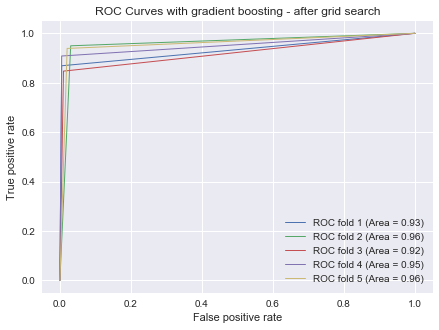

In [129]:
gb_pipe2 = Pipeline([('boosting', GradientBoostingClassifier(n_estimators=70, max_depth=5, min_samples_split=100, subsample=0.8, max_features = 'sqrt'))])
five_fold_roc_curves(gb_pipe2, X_rs2, y_rs2, title ="with gradient boosting - after grid search")

In [134]:
def kfold_perfomance(clc, data, target):
    # clc is the classifier in question
    kfold = KFold(n_splits = 5)
    total_score = 0
    for ind_train, ind_test in kfold.split(data):
        clc.fit(data.iloc[ind_train], target.iloc[ind_train])
        score = clc.score(data.iloc[ind_test], target.iloc[ind_test])
        total_score += score
        print("Classifier Score =", score)
    print("Average classifier score =", total_score/5)
    return total_score/5

In [136]:
kfold_perfomance(svm_pipe, X_rs2, y_rs2)

Classifier Score = 0.662162162162
Classifier Score = 0.684745762712
Classifier Score = 0.722033898305
Classifier Score = 0.661016949153
Classifier Score = 0.71186440678
Average classifier score = 0.688364635822


0.68836463582226293

In [137]:
kfold_perfomance(rf_pipe_b2, X_rs2, y_rs2)

Classifier Score = 0.956081081081
Classifier Score = 0.925423728814
Classifier Score = 0.95593220339
Classifier Score = 0.959322033898
Classifier Score = 0.935593220339
Average classifier score = 0.946470453504


0.94647045350435177

In [138]:
kfold_perfomance(lr_pipe, X_rs2, y_rs2)

Classifier Score = 0.918918918919
Classifier Score = 0.918644067797
Classifier Score = 0.952542372881
Classifier Score = 0.952542372881
Classifier Score = 0.928813559322
Average classifier score = 0.93429225836


0.93429225836005492

In [139]:
kfold_perfomance(gb_pipe2, X_rs2, y_rs2)

Classifier Score = 0.959459459459
Classifier Score = 0.942372881356
Classifier Score = 0.95593220339
Classifier Score = 0.962711864407
Classifier Score = 0.952542372881
Average classifier score = 0.954603756299


0.95460375629867156